In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
import torch
from torchvision import models, transforms

# Paths
TRAIN_DIR = "/kaggle/input/soil-classification/soil_classification-2025/train"
TEST_DIR = "/kaggle/input/soil-classification/soil_classification-2025/test"
TRAIN_LABELS = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv")
TEST_IDS = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv")

In [2]:
# Encode labels
le = LabelEncoder()
TRAIN_LABELS['label'] = le.fit_transform(TRAIN_LABELS['soil_type'])

In [3]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
import torch
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 model (ImageNet weights) for feature extraction
model_cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_cnn.fc = torch.nn.Identity()  # remove classification head to get features

# Move model to device and set to evaluation mode
model_cnn = model_cnn.to(device)
model_cnn.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Feature extractor function
def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths, desc="Extracting features"):
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model_cnn(img_tensor).cpu().numpy().flatten()
        features.append(feat)
    return np.array(features)

# Prepare paths
TRAIN_LABELS['filepath'] = TRAIN_LABELS['image_id'].apply(lambda x: os.path.join(TRAIN_DIR, x))
TEST_IDS['filepath'] = TEST_IDS['image_id'].apply(lambda x: os.path.join(TEST_DIR, x))

# Extract features
train_features = extract_features(TRAIN_LABELS['filepath'].values)
test_features = extract_features(TEST_IDS['filepath'].values)

Extracting features: 100%|██████████| 341/341 [00:05<00:00, 57.27it/s]


In [6]:
# Train ML classifier
X = train_features
y = TRAIN_LABELS['label'].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"--- Fold {fold+1} ---")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X[train_idx], y[train_idx])
    val_preds = clf.predict(X[val_idx])
    print(classification_report(y[val_idx], val_preds, target_names=le.classes_))
    all_preds.append(f1_score(y[val_idx], val_preds, average='macro'))

print("Average F1 across folds:", np.mean(all_preds))

--- Fold 1 ---
               precision    recall  f1-score   support

Alluvial soil       0.95      0.93      0.94       106
   Black Soil       0.95      0.91      0.93        46
    Clay soil       1.00      0.93      0.96        40
     Red soil       0.87      0.98      0.92        53

     accuracy                           0.94       245
    macro avg       0.94      0.94      0.94       245
 weighted avg       0.94      0.94      0.94       245

--- Fold 2 ---
               precision    recall  f1-score   support

Alluvial soil       0.95      0.94      0.95       106
   Black Soil       0.98      0.94      0.96        47
    Clay soil       0.90      0.90      0.90        40
     Red soil       0.93      0.98      0.95        52

     accuracy                           0.94       245
    macro avg       0.94      0.94      0.94       245
 weighted avg       0.94      0.94      0.94       245

--- Fold 3 ---
               precision    recall  f1-score   support

Alluvial soil

In [7]:
# Train on full data & predict test
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X, y)
test_preds = final_model.predict(test_features)
test_labels = le.inverse_transform(test_preds)

In [8]:
# Save submission
submission = pd.DataFrame({
    'image_id': TEST_IDS['image_id'],
    'soil_type': test_labels
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved.")

Submission file saved.


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...


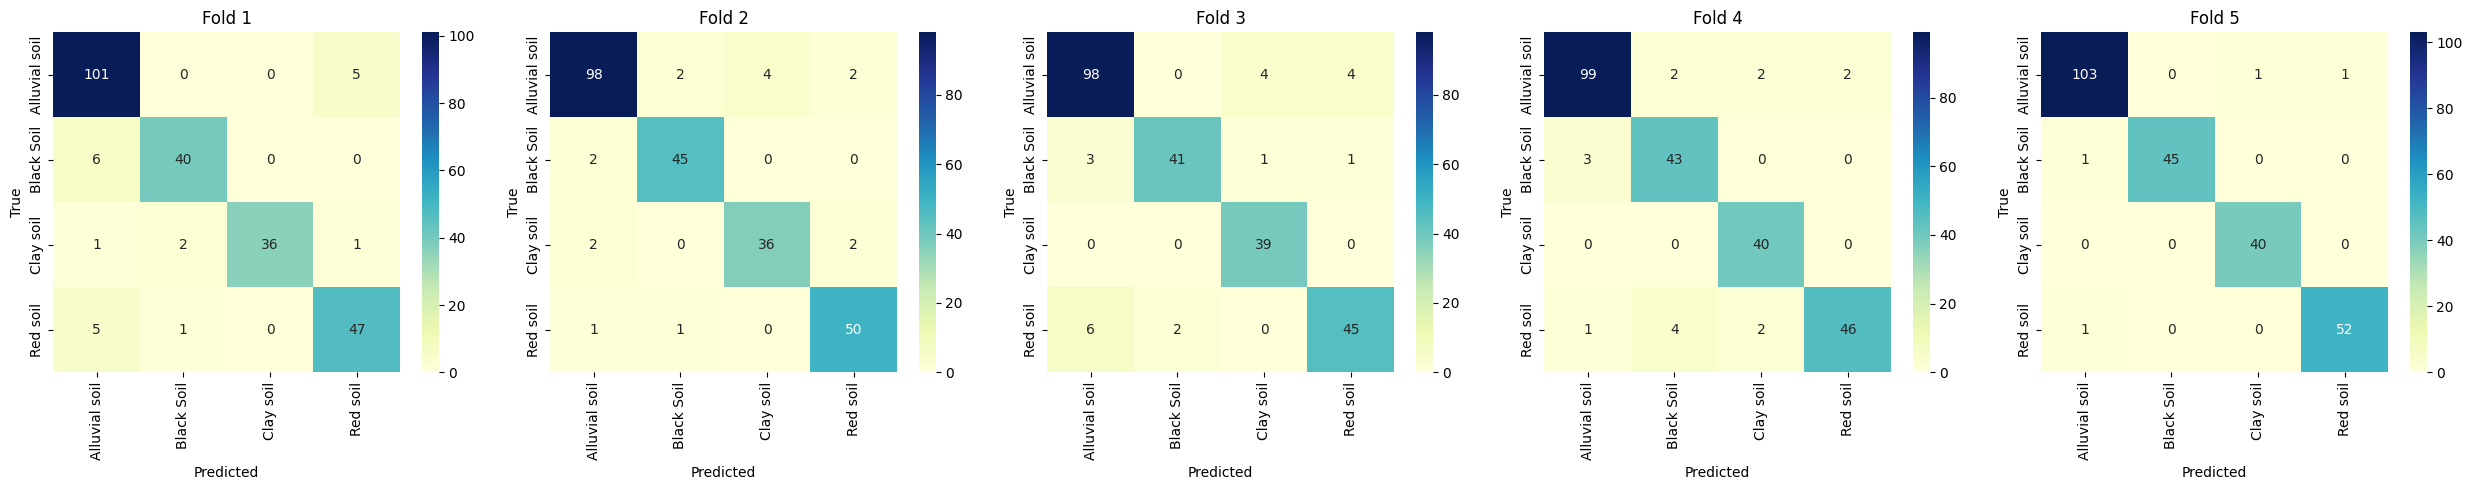

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Reinitialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optional: Reduce for testing speed (increase to 100 later)
n_estimators = 20

# Setup figure
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Processing Fold {fold + 1}...")
    
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    clf.fit(X[train_idx], y[train_idx])
    
    val_preds = clf.predict(X[val_idx])
    cm = confusion_matrix(y[val_idx], val_preds)
    
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, 
                ax=axes[fold], cmap="YlGnBu")
    axes[fold].set_title(f'Fold {fold + 1}')
    axes[fold].set_xlabel("Predicted")
    axes[fold].set_ylabel("True")

plt.tight_layout()
plt.show()


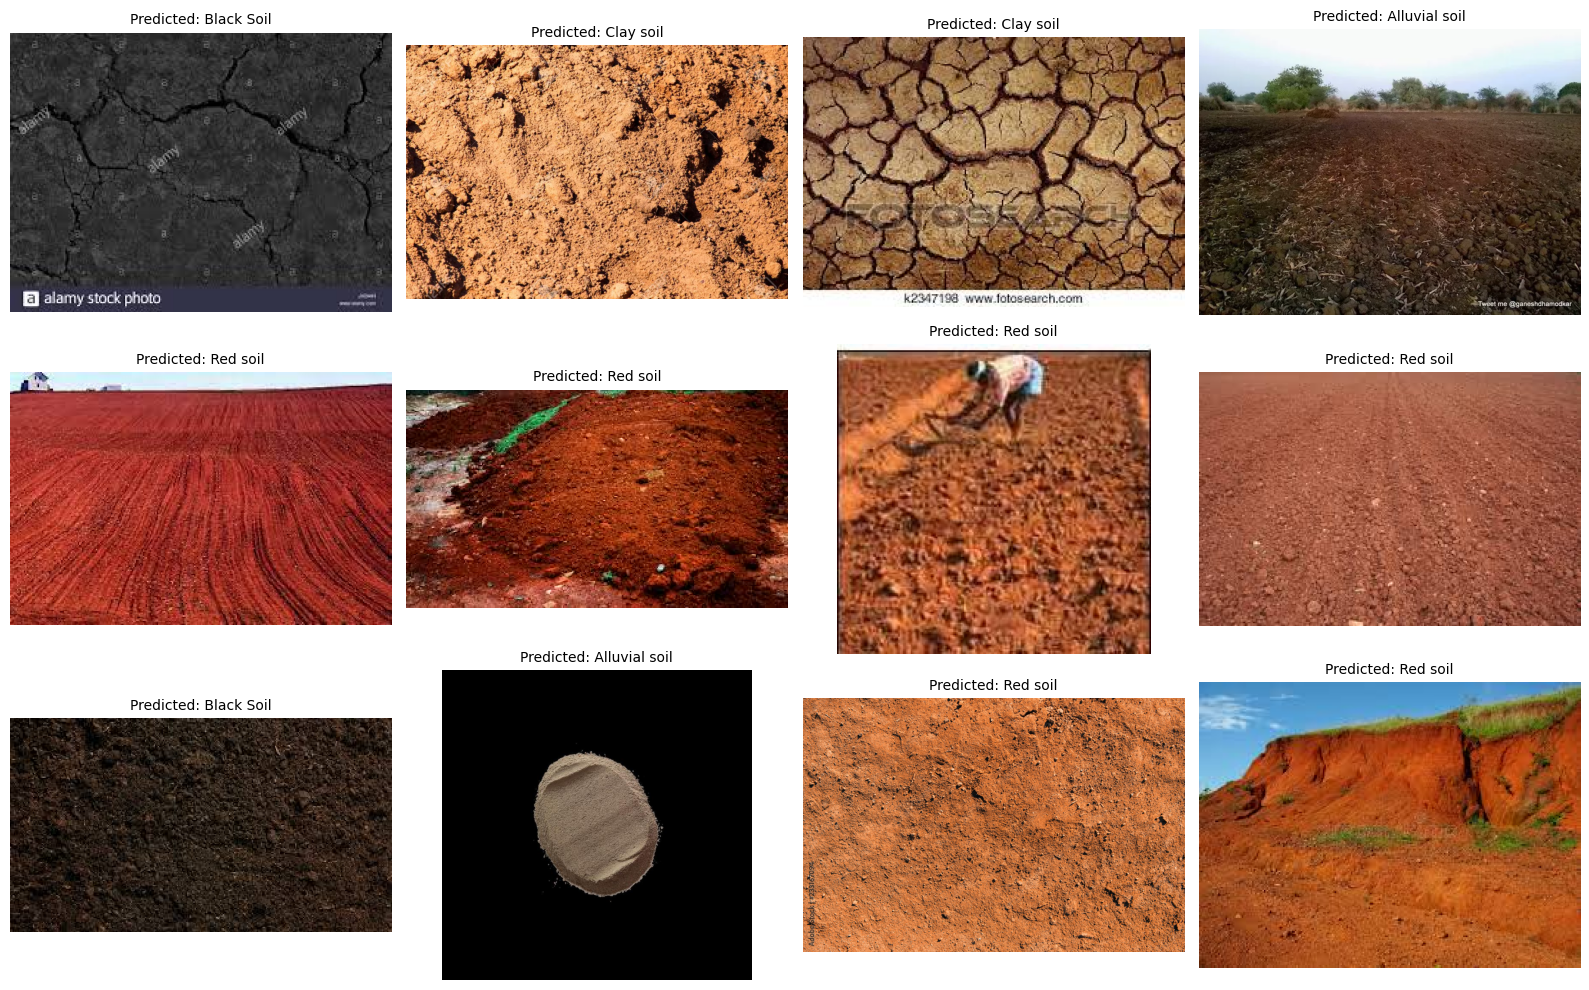

In [10]:
# Show sample test predictions
sample_df = submission.sample(12, random_state=42)

plt.figure(figsize=(16, 10))
for i, row in enumerate(sample_df.itertuples(), 1):
    img_path = os.path.join(TEST_DIR, row.image_id)
    img = Image.open(img_path).convert("RGB")
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(f"Predicted: {row.soil_type}", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()